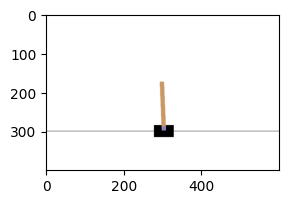

In [1]:
import gym


#定义环境
class MyWrapper(gym.Wrapper):

    def __init__(self):
        env = gym.make('CartPole-v1',
                       render_mode='rgb_array',)

        super().__init__(env)
        self.env = env
        self.step_n = 0

    def reset(self):
        state, _ = self.env.reset()
        self.step_n = 0
        return state

    # step 就是進行了一次行動
    def step(self, action):
        state, reward, terminated, truncated, info = self.env.step(action)
        over = terminated or truncated

        #限制最大步数
        self.step_n += 1
        if self.step_n >= 200:
            over = True
        
        #没坚持到最后,扣分
        if over and self.step_n < 200:
            reward = -1000

        return state, reward, over

    #打印游戏图像
    def show(self):
        from matplotlib import pyplot as plt
        plt.figure(figsize=(3, 3))
        plt.imshow(self.env.render())
        plt.show()



       

    # #打印游戏图像
    # def show(self):
    #     from matplotlib import pyplot as plt
    #     import numpy as np
    #     img = self.env.render()
    #     print("DEBUG type:", type(img), "shape:", getattr(img, "shape", None))
    #     if not isinstance(img, np.ndarray):
    #         try:
    #             img = np.array(img)
    #             print("DEBUG after np.array, type:", type(img), "shape:", getattr(img, "shape", None))
    #         except Exception as e:
    #             print("ERROR to np.array:", e)
    #             return
    #     print("DEBUG nan count:", np.isnan(img).sum(), "inf count:", np.isinf(img).sum())
    #     plt.figure(figsize=(3, 3))
    #     plt.imshow(img)
    #     plt.axis("off")
    #     plt.show()

    # def show(self):
    #     import numpy as np
    #     from matplotlib import pyplot as plt
    #     from IPython.display import clear_output, display

    #     # 取得 rgb_array
    #     img = self.env.render()

    #     # 保證是 numpy 陣列
    #     if not isinstance(img, np.ndarray):
    #         img = np.array(img)

    #     # 第一次呼叫時建立 fig/ax
    #     if not hasattr(self, '_fig_ax'):
    #         self._fig_ax = plt.subplots(figsize=(3, 3))
    #     fig, ax = self._fig_ax

    #     # 清除上一張、畫新圖
    #     ax.clear()
    #     ax.imshow(img)
    #     ax.axis('off')

    #     # 利用 IPython 介面更新
    #     clear_output(wait=True)
    #     display(fig)

    #     # 暫停一下讓畫面有機會刷新
    #     plt.pause(0.5)


env = MyWrapper()

env.reset()

env.show()

In [2]:
import torch
import torch.nn as nn

# 定義 Q 網路類別
class QNetwork(nn.Module):
    def __init__(self, input_dim=4, hidden_dim=64, output_dim=2):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, output_dim)
        )

    def forward(self, x):
        return self.model(x)

# 定義複製模型參數的函數
def clone_model(model):
    clone = QNetwork()  # 這裡假設結構一樣
    clone.load_state_dict(model.state_dict())
    return clone

# 建立主模型
model = QNetwork()
# 用 clone_model 複製出 target 模型
model_delay = clone_model(model)

In [3]:
from IPython import display
import random


#玩一局游戏并记录数据
def play(show=False):
    data = []
    reward_sum = 0

    state = env.reset()
    over = False
    while not over:
        action = model(torch.FloatTensor(state).reshape(1, 4)).argmax().item()
        if random.random() < 0.1:
            action = env.action_space.sample()

        next_state, reward, over = env.step(action)

        data.append((state, action, reward, next_state, over))
        reward_sum += reward

        state = next_state

        if show:
            display.clear_output(wait=True)
            env.show()

    return data, reward_sum


play()[-1]

d:\it_project\github_sync\ml-workshop\.venv\lib\site-packages\gym\utils\passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


-992.0

In [6]:
#数据池
class Pool:

    def __init__(self):
        self.pool = []
        self.prob = []

    def __len__(self):
        return len(self.pool)

    def __getitem__(self, i):
        return self.pool[i]

    #更新动作池
    def update(self):
        #每次更新不少于N条新数据
        old_len = len(self.pool)
        while len(pool) - old_len < 200:
            data = play()[0]
            self.pool.extend(data)
            #维护概率表
            self.prob.extend([1.0] * len(data))

        #只保留最新的N条数据
        self.pool = self.pool[-2_0000:]
        self.prob = self.prob[-2_0000:]

    #获取一批数据样本
    def sample(self):
        idx = torch.FloatTensor(self.prob).clamp(0.1, 1.0).multinomial(
            num_samples=64, replacement=False)

        data = [self.pool[i] for i in idx]

        state = torch.FloatTensor([i[0] for i in data]).reshape(-1, 4)
        action = torch.LongTensor([i[1] for i in data]).reshape(-1, 1)
        reward = torch.FloatTensor([i[2] for i in data]).reshape(-1, 1)
        next_state = torch.FloatTensor([i[3] for i in data]).reshape(-1, 4)
        over = torch.LongTensor([i[4] for i in data]).reshape(-1, 1)

        return idx, state, action, reward, next_state, over


pool = Pool()
pool.update()
pool.sample()

len(pool), pool[0]

C:\Users\User\AppData\Local\Temp\ipykernel_94712\919455838.py:35: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\utils\tensor_new.cpp:204.)
  state = torch.FloatTensor([i[0] for i in data]).reshape(-1, 4)


(205,
 (array([-0.04961158, -0.04185072,  0.03164864, -0.03909233], dtype=float32),
  0,
  1.0,
  array([-0.05044859, -0.23741187,  0.0308668 ,  0.26340565], dtype=float32),
  False))

In [7]:
#训练
def train():
    model.train()
    optimizer = torch.optim.Adam(model.parameters(), lr=2e-4)
    loss_fn = torch.nn.MSELoss(reduction='none')

    #共更新N轮数据
    for epoch in range(1000):
        pool.update()

        #每次更新数据后,训练N次
        for i in range(200):

            #采样N条数据
            idx, state, action, reward, next_state, over = pool.sample()

            #计算value
            value = model(state).gather(dim=1, index=action)

            #计算target
            with torch.no_grad():
                target = model_delay(next_state)
            target = target.max(dim=1)[0].reshape(-1, 1)
            target = target * 0.99 * (1 - over) + reward

            #根据概率缩放loss
            r = torch.FloatTensor([pool.prob[i] for i in idx])
            r = (1 - r).clamp(0.1, 1.0).reshape(-1, 1)

            loss = loss_fn(value, target)
            (loss * r).mean(0).backward()
            optimizer.step()
            optimizer.zero_grad()

            #根据loss调整数据权重
            for i, j in zip(idx.tolist(),
                            loss.abs().sigmoid().flatten().tolist()):
                pool.prob[i] = j

        #复制参数
        if (epoch + 1) % 5 == 0:
            model_delay.load_state_dict(model.state_dict())

        if epoch % 100 == 0:
            test_result = sum([play()[-1] for _ in range(20)]) / 20
            print(epoch, len(pool), pool.prob[::5000], test_result)


train()

0 414 [0.8033244013786316] -908.85
100 20000 [1.0, 0.5004331469535828, 0.780116617679596, 0.6994686722755432] 200.0
200 20000 [0.5525766611099243, 0.5362000465393066, 0.572137176990509, 0.5222194194793701] 140.75
300 20000 [0.6254777312278748, 0.6788462996482849, 0.9284080862998962, 0.653100311756134] 200.0
400 20000 [0.5134698152542114, 0.5289112329483032, 0.6167893409729004, 0.5072288513183594] 200.0
500 20000 [0.5050920248031616, 0.5200597047805786, 0.650956392288208, 0.5899918675422668] 200.0
600 20000 [0.5310229659080505, 0.5424301624298096, 0.5678628087043762, 0.5086170434951782] 200.0
700 20000 [0.6195623874664307, 0.5062025189399719, 0.9999315738677979, 0.5046674013137817] 200.0
800 20000 [0.9812164902687073, 0.5086759328842163, 0.5515159368515015, 1.0] -854.5
900 20000 [0.5011523962020874, 1.0, 0.9876075387001038, 0.5000438690185547] -254.1


In [ ]:
play(True)[-1]

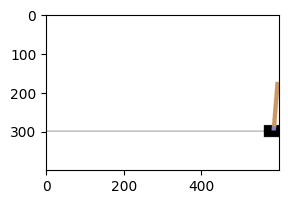

200.0

In [14]:
play(True)[-1]

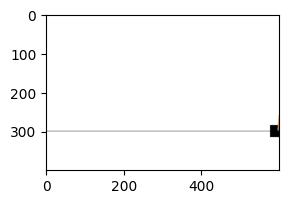

-802.0

In [15]:
play(True)[-1]

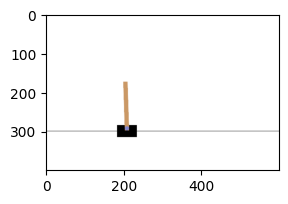

200.0

In [16]:
play(True)[-1]

In [17]:
import torch

model = QNetwork()
model_delay = clone_model(model)
pool = Pool()       # 重新開一個資料池
pool.update()       # 重新收集資料

def train_with_save_best_model():
    model.train()
    optimizer = torch.optim.Adam(model.parameters(), lr=2e-4)
    loss_fn = torch.nn.MSELoss()
    best_score = float('-inf')  # 記錄最高分
    best_epoch = -1             # 記錄最高分是哪個 epoch

    for epoch in range(1000):
        pool.update()
        for i in range(200):
            state, action, reward, next_state, over = pool.sample()

            value = model(state).gather(dim=1, index=action)
            with torch.no_grad():
                target = model_delay(next_state)
            target = target.max(dim=1)[0].reshape(-1, 1)
            target = target * 0.99 * (1 - over) + reward

            loss = loss_fn(value, target)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

        # target network 更新
        if (epoch + 1) % 5 == 0:
            model_delay.load_state_dict(model.state_dict())

        # 每100回合評估一次
        if epoch % 100 == 0:
            test_result = sum([play()[-1] for _ in range(20)]) / 20
            print(f"Epoch {epoch}, Pool Size: {len(pool)}, Test Score: {test_result:.2f}")
            # 如果這次分數比以前高，就存下來
            if test_result > best_score:
                best_score = test_result
                best_epoch = epoch
                torch.save(model.state_dict(), 'best_model.pth')
                print(f"Best model saved at epoch {epoch} with score {test_result:.2f}")

    print(f"訓練結束，最高分：{best_score:.2f}，出現在 epoch {best_epoch}，模型已存為 'best_model.pth'。")


train_with_save_best_model()


Epoch 0, Pool Size: 415, Test Score: -982.25
Best model saved at epoch 0 with score -982.25
Epoch 100, Pool Size: 20000, Test Score: 148.90
Best model saved at epoch 100 with score 148.90
Epoch 200, Pool Size: 20000, Test Score: 200.00
Best model saved at epoch 200 with score 200.00
Epoch 300, Pool Size: 20000, Test Score: 141.30
Epoch 400, Pool Size: 20000, Test Score: 90.25
Epoch 500, Pool Size: 20000, Test Score: 200.00
Epoch 600, Pool Size: 20000, Test Score: 200.00
Epoch 700, Pool Size: 20000, Test Score: -356.95
Epoch 800, Pool Size: 20000, Test Score: 200.00
Epoch 900, Pool Size: 20000, Test Score: 200.00
訓練結束，最高分：200.00，出現在 epoch 200，模型已存為 'best_model.pth'。


In [18]:
best_model = QNetwork()
best_model.load_state_dict(torch.load('best_model.pth'))

<All keys matched successfully>

In [19]:
def play_with_model(model, show=False):
    data = []
    reward_sum = 0

    state = env.reset()
    over = False
    while not over:
        action = model(torch.FloatTensor(state).reshape(1, 4)).argmax().item()
        if random.random() < 0.1:
            action = env.action_space.sample()

        next_state, reward, over = env.step(action)

        data.append((state, action, reward, next_state, over))
        reward_sum += reward

        state = next_state

        if show:
            display.clear_output(wait=True)
            env.show()

    return data, reward_sum


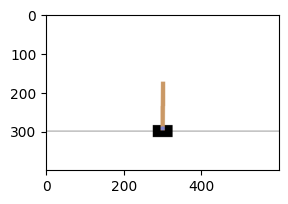

Best model 得分： 200.0


In [20]:
score = play_with_model(best_model, show=True)[-1]
print("Best model 得分：", score)